# part0: imports

In [1]:
%matplotlib inline


import os, sys, pathlib
from pprint import pprint
import gc, time
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import PyPDF2 as ppdf
import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score


import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import matplotlib.lines as mlines
from matplotlib.ticker import MaxNLocator, FormatStrFormatter
from matplotlib.collections import LineCollection


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    # %run "fig2.ipynb"

    print('Done')

the variable `GoodDataList` contains the session names
Done


# Part 1

functions that plot each panel.

---

CCA for the example sessions

In [2]:
@utility.report
def plot_cca_for_ex(ax,):
    defs = monkey_defs
    raster_example = defs.raster_example
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = defs.prep_general(dt.load_pyal_data(path))
        raster_example_df.append(df)
    
    df1, df2 = raster_example_df
    AllData1 = dt.get_data_array(df1, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    AllData2 = dt.get_data_array(df2, defs.exec_epoch, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T
    
    # lower bound
    len_trial = int(np.round(np.diff(defs.WINDOW_exec)/defs.BIN_SIZE))
    AllDataL1 = defs._get_data_array(df1, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    AllDataL2 = defs._get_data_array(df2, epoch_L=len_trial, area=defs.areas[2], model=defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllDataL1.shape,AllDataL2.shape),axis=0)
    CCsL=[]
    for sessionData1,sessionData2 in zip(AllDataL1,AllDataL2):
        r = []
        for n in range(params.n_iter * 10):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T
    
    # upper bound
    AllDataU = dt.get_data_array([df1,df2], monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    n_shared_trial1 = AllDataU.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate(AllDataU):
        r = []
        for n in range(params.n_iter * 10):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,monkey_defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,monkey_defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    x_ = np.arange(1,monkey_defs.n_components+1)
    ax.plot(x_, allCCs, color=params.colors.MainCC, marker = 'o', label=f'Across monkeys')
    ax.plot(x_, CCsU[:,0], color=params.colors.UpperCC, marker = '<', ls='--', label=f'Within monkey1')
    ax.plot(x_, CCsU[:,1], marker = '<', ls='--', label=f'Within monkey2')
    ax.plot(x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':', label=f'Control')


    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,monkey_defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.set_title(f'{defs.areas[2]} Alignment')
    ax.legend(loc=(.55,.67))
    ax.set_ylabel('Canonical correlation')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,monkey_defs.n_components])
    ax.spines['left'].set_bounds([0,1])

Executed: `plot_cca_for_ex` in 6.3s


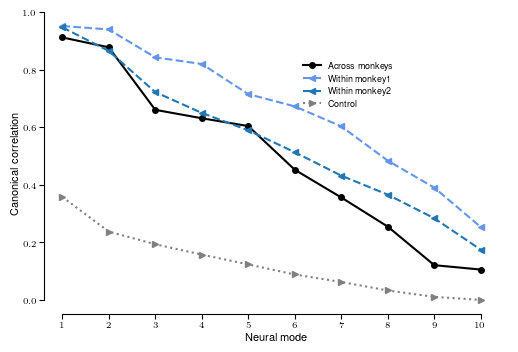

In [3]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig,ax = plt.subplots(dpi=100)
    
    plot_cca_for_ex(ax)
    

---

monkey population CCA plot

In [92]:
@utility.report
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

---

Mouse CCA plot

In [3]:
@utility.report
def get_full_mouse_data():
    defs = mouse_defs
    
    animalList = ['mouse-data']
    animalFiles = []
    for animal in animalList:
        animalFiles.extend(utility.find_file(root / animal, 'mat'))

    AllDFs=[]
    for fname in animalFiles:
        df = dt.load_pyal_data(fname)
        df['mouse'] = fname.split(os.sep)[-1][fname.split(os.sep)[-1].find('WR'):].split('_')[0]
        df['file'] = fname.split(os.sep)[-1]
        df = defs.prep_general_mouse(df)
        AllDFs.append(df)

    allDFs_M1 = []
    for df in AllDFs:
        if 'M1_rates' in df.columns:
            allDFs_M1.append(df)


    allDFs_Str = []
    for df in AllDFs:
        if 'Str_rates' in df.columns:
            allDFs_Str.append(df)
            
    return allDFs_M1, allDFs_Str

# Part 2
Plot figure

In [2]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    %matplotlib inline
    figsize=params.LargeFig
    fig=plt.figure(figsize=figsize)
    
   

    ##########################################
    # 1: schematics
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0, 
                                    bottom=figsize[1]-params.panels.schmatic[1], 
                                    width=params.panels.schmatic[0], 
                                    height=params.panels.schmatic[1])
    ax1   =fig.add_subplot(gs1[0])
    ax1 = utility.phantom_axes(ax1)
    ax1.set_facecolor([0,0,0,0])


    ##########################################
    # 2: Raster
    gs2_1 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=params.panels.schmatic[0],
                                     bottom=figsize[1]-params.panels.schmatic[1]+params.panels.velocity[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.raster[1])
    gs2_2 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     right=figsize[0],
                                     top=figsize[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.raster[1])
    
    gs2_3 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=params.panels.schmatic[0],
                                     bottom=figsize[1]-params.panels.schmatic[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.velocity[1])
    gs2_4 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     right=figsize[0],
                                     top=figsize[1]-params.panels.raster[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.velocity[1])

    
    raster_example_df = prep_example_df()
    
    axes2_1 = plot_moneky_fr_raster(raster_example_df[0], gs2_1)
    axes2_2 = plot_moneky_fr_raster(raster_example_df[1], gs2_2)
    utility.phantom_axes(fig.add_subplot(gs2_1[:])).set_title('Monkey1', pad=8)
    utility.phantom_axes(fig.add_subplot(gs2_2[:])).set_title('Monkey2', pad=8)
    
    axes2_3 = plot_moneky_vel_ex(raster_example_df[0], gs2_3)
    axes2_4 = plot_moneky_vel_ex(raster_example_df[1], gs2_4)

    axes2_3[0].set_ylabel('Position\n(scaled)')
    axes2_3[0].set_xlabel('Time relative to movement onset',loc='left')
    X_line = mlines.Line2D([], [], color='blue', label='$X$')
    Y_line = mlines.Line2D([], [], color='red', label='$Y$')
    axes2_4[-1].legend(handles=[X_line, Y_line], loc=(1.1,.1))
        
    gs2_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, 
                                     height=params.panels.raster[1]-.15, 
                                     width=.1, 
                                     left=figsize[0]+.2, 
                                     bottom=figsize[1]-params.panels.schmatic[1]+params.panels.velocity[1])
    cax2 = fig.add_subplot(gs2_c[:])
    fig.colorbar(cm.ScalarMappable(),cax=cax2, ticks=(0,1),drawedges=False)
    cax2.set_title('Normalised\nfiring rate')


    
    
    ##########################################
    # 3: 3D projections
    gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=5, left=0, 
                                    bottom=figsize[1]-params.panels.schmatic[1]-params.panels.proj_3d_align[1]-.3,
                                    width=params.panels.proj_3d_align[0], 
                                    height=params.panels.proj_3d_align[1])

    
    axes3 = plot_monkey_pc_example(raster_example_df, gs3)
    
    
    gs3_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0,
                                    bottom=(axes3[0].get_position().y0+axes3[0].get_position().y1)/2*figsize[1],
                                    width=.2, height=0.2)
    cax3 = fig.add_subplot(gs3_c[0],zorder=10)

    utility.plot_targets(cax3,3)
    cax3.set_xlim(np.array(cax3.get_xlim())*1.15)
    cax3.set_ylim(np.array(cax3.get_ylim())*1.15)

    
    ##########################################
    # 4: CCA plot for the example animals
    gs4   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    left=0,
                                    bottom=gs3.bottom*figsize[1]-params.panels.cca[1]-.3, 
                                    width=params.panels.cca[0],
                                    height=params.panels.cca[1])

    ax4 = fig.add_subplot(gs4[0])
    
    plot_cca_for_ex(ax4)
    

    
    
    ##########################################
    # 5: CCA plot for population
    gs5 = fig.add_gridspec(nrows=1, ncols=2,  width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                           left=gs4.right+(.7/figsize[0]),  # .7" offset
                           right=gs4.right+ (.7/figsize[0]) + params.panels.cca_hist[0]/figsize[0],
                           bottom=gs4.bottom,
                           top=gs4.top,
                           wspace=0)

    ax5 = fig.add_subplot(gs5[0])
    ax5_ = fig.add_subplot(gs5[1])

    
    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca(ax5,ax5_, full_list_MCx, allDFs_MCx)
    
    
    
    ##########################################
    # 6: Decoding for monkeys
    gs6   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=gs5.top*figsize[1],
                                    right=figsize[0],
                                    width=params.panels.decoding_hist[0],
                                    height=params.panels.decoding_hist[1])

    ax6 = fig.add_subplot(gs6[0])

       
    plot_monkey_decoding(ax6, full_list_MCx, allDFs_MCx)

    
    
    ##########################################
    # 7: schematics Mouse
    gs7   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0, 
                                    bottom=gs6.bottom*figsize[1]-params.panels.schmatic[1],
                                    width=params.panels.schmatic[0],
                                    height=params.panels.cca[1])
    ax7   =fig.add_subplot(gs7[0])
    ax7 = utility.phantom_axes(ax7)
    ax7.set_facecolor([0,1,0,0])

    
    
    
    ##########################################
    # 8: CCA plot for MICE
    gs8 = fig.add_gridspec(nrows=1, ncols=2,  width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                           left=gs5.left,
                           right=gs5.right,
                           bottom=gs7.bottom,
                           top=gs7.top,
                           wspace=0)

    ax8 = fig.add_subplot(gs8[0])
    ax8_ = fig.add_subplot(gs8[1])
    
    
    allDFs_M1, _ = get_full_mouse_data()
    
    plot_mouse_cca(ax8,ax8_, allDFs_M1)
    
    
    
    ##########################################
    # 9: Behaviour vs CCA
    gs9   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    top=gs7.top*figsize[1],
                                    right=figsize[0],
                                    width=params.panels.neuro_behav_corr[0],
                                    height=params.panels.neuro_behav_corr[1])
    gs9_inset   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                                left=gs9.right*figsize[0]-.7,
                                                bottom=gs9.bottom*figsize[1]+.1,
                                                width=.7,
                                                height=params.panels.TinyH)
    ax9 = fig.add_subplot(gs9[0])
    ax9_ = fig.add_subplot(gs9_inset[0])


    
    plot_mouse_cca_corr(ax9, allDFs_M1)
    plot_monkey_cca_corr(ax9, allDFs_MCx)

    plot_traj_corr(ax9_, allDFs_MCx, allDFs_M1)


    
    
#     fig.align_ylabels([ax1,ax4])
    #############################################
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    AXES=(ax1,axes2_1[0],axes3[0],ax4,ax5,ax6,ax7,ax8,ax9)
    OFFX=np.array([.02]*len(AXES))
    OFFY=np.array([.01]*len(AXES))
    # OFFX[[-1]]=0.12
    OFFX[[0,2,3,4,5,6,7,8]]=0.05
    
    params.add_panel_caption(axes=AXES, offsetX=OFFX, offsetY=OFFY)
    
    fig.savefig(params.figPath / 'figure2.pdf', format='pdf', bbox_inches='tight')
    

    ##########################################
    # monkey schematics
 
    thisPath  =str(params.figPath / 'figure2.pdf')
    sketchPath=str(params.figPath / 'monkey-task-schematic.pdf')
    if os.path.exists(sketchPath):
        f1=ppdf.PdfFileReader(thisPath).getPage(0)
        f2=ppdf.PdfFileReader(sketchPath).getPage(0)

        f1.mergeTranslatedPage(page2=f2, tx=10, ty=347, expand=False)

        writer=ppdf.PdfFileWriter()
        writer.addPage(f1)
        with open(thisPath,'wb') as f3:
            writer.write(f3)



    ##########################################
    # mouse schematics
            
    thisPath  =str(params.figPath / 'figure2.pdf')
    sketchPath=str(params.figPath / 'mouse-task-schematic.pdf')
    if os.path.exists(sketchPath):
        f1=ppdf.PdfFileReader(thisPath).getPage(0)
        f2=ppdf.PdfFileReader(sketchPath).getPage(0)

        f1.mergeTranslatedPage(page2=f2, tx=10, ty=20, expand=False)

        writer=ppdf.PdfFileWriter()
        writer.addPage(f1)
        with open(thisPath,'wb') as f3:
            writer.write(f3)

Executed: `plot_moneky_fr_raster` in 0.1s
Executed: `plot_moneky_fr_raster` in 0.1s
Executed: `plot_moneky_vel_ex` in 0.1s
Executed: `plot_moneky_vel_ex` in 0.2s
Executed: `plot_monkey_pc_example` in 0.3s
Executed: `plot_cca_for_ex` in 4.3s
Executed: `get_full_monkey_data` in 16.3s
Executed: `plot_monkey_cca` in 360.5s
Executed: `plot_monkey_decoding` in 202.8s
Executed: `get_full_mouse_data` in 1.2s
Executed: `plot_mouse_cca` in 14.0s
Executed: `plot_mouse_cca_corr` in 13.5s
Executed: `plot_monkey_cca_corr` in 138.0s
Executed: `plot_traj_corr` in 1.6s
